### Process data from CDP Full Cities 2022 dataset: https://data.cdp.net/Governance/2022-Full-Cities-Dataset/gd5v-pfcg

In [1]:
import os

import fasttext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.cloud import translate_v2 as translate
from tqdm import tqdm

In [2]:
# enables tqdm for pandas
tqdm.pandas()

In [3]:
# google api key
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-hunter-379918-694c8224f026.json'

In [4]:
# load csv as dataframe
df_csv = pd.read_csv('csvs/cdp.csv', sep=',')
df_csv

,Questionnaire,Organization Number,Organization Name,City,Country,CDP Region,Reporting Authority,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
0,Cities 2022,15014,City of Prague,Prague,Czechia,Europe,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,1,Project area,3,NaN,Energy efficiency (including public lighting),NaN,NaN,03/03/2023 02:34:52 AM
1,Cities 2022,31056,Edinburgh City Council,Edinburgh,United Kingdom of Great Britain and Northern I...,Europe,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,6,Project description and attach project proposal,12,NaN,The City of Edinburgh Council is now developin...,NaN,NaN,03/03/2023 02:34:52 AM
2,Cities 2022,859154,Hokuei Town,NaN,Japan,East Asia,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,1,Project area,0,NaN,NaN,NaN,NaN,03/03/2023 02:34:52 AM
3,Cities 2022,834126,Dobong-gu District of Seoul,NaN,Republic of Korea,East Asia,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,6,Project description and attach project proposal,2,NaN,Create a public building BIPV landmark by inst...,NaN,도봉구청사 건물일체형태양광 랜드마크 조성사업 발주계획.pdf,03/03/2023 02:34:52 AM
4,Cities 2022,35865,Municipality of Fortaleza,Fortaleza,Brazil,Latin America,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,6,Project description and attach project proposal,7,NaN,O projeto de arborização em corredores de tran...,Para que a cidade alcance a neutralidade climá...,ARBORIZAR.pdf,03/03/2023 02:34:52 AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7114,Cities 2022,36494,City of Padua,Padova,Italy,Europe,CDP Cities; European Climate Pact; ICLEI - Loc...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,2,Project title,5,NaN,2ISECAP,NaN,NaN,03/03/2023 02:34:52 AM
7115,Cities 2022,60381,Alcaldía Distrital de Santa Marta,Santa Marta,Colombia,Latin America,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,2,Project title,2,NaN,ESTABLECIMIENTO Y PLANIFICACIÓN DEL BOSQUE URB...,NaN,NaN,03/03/2023 02:34:52 AM
7116,Cities 2022,31182,"City of San Francisco, CA",San Francisco,United States of America,United States of America,C40; CDP Cities; CDP Investor - Local Governme...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,6,Project description and attach project proposal,6,NaN,Solar Power Generation Feasibility Study. SFO ...,NaN,NaN,03/03/2023 02:34:52 AM
7117,Cities 2022,60341,Prefeitura de Rio Grande,NaN,Brazil,Latin America,CDP Cities; ICLEI - Local Governments for Sust...,7. Planning,Finance,7.4,Describe any planned climate-related projects ...,1,Project area,1,NaN,No relevant projects,NaN,NaN,03/03/2023 02:34:52 AM


In [5]:
# 1 -> project area
# 2 -> project title
# 6 -> project description
# id: organization number + row number (2373 samples) 
df_relevant = df_csv[['Organization Number', 'Row Number', 'Column Number', 'Response Answer']]
df_area = df_relevant[df_relevant['Column Number'] == 1]
df_title = df_relevant[df_relevant['Column Number'] == 2]
df_desc = df_relevant[df_relevant['Column Number'] == 6]
df_joined = pd.merge(df_area, df_title, on=['Organization Number', 'Row Number'])
df_joined = pd.merge(df_joined, df_desc, on=['Organization Number', 'Row Number'])
df_joined = df_joined.rename(columns={'Response Answer_x': 'area', 'Response Answer_y': 'title', 'Response Answer': 'desc'})
df_joined = df_joined[['area', 'title', 'desc']]
df_joined

,area,title,desc
0,Energy efficiency (including public lighting),Intensity control of LED light points for high...,Gradual use of control elements capable of red...
1,NaN,NaN,NaN
2,Waste management (including waste recycling),Instalación de planta trituradora de llantas.,Como medida de solución permanente para la dis...
3,Transport,Seguimiento y control ambiental a tecnologías ...,"En la actualidad, se encuentran disponibles mú..."
4,Waste management (including waste recycling),Fortalecimiento programa de reciclaje inclusivo,Este programa ayuda a dignificar y oficializar...
...,...,...,...
2368,Water management,Greater Amman Municipality (GAM) - Saqef al Se...,This project has two main goals. Firstly mitig...
2369,Water management,Estrategia Hidrica Local,Herramienta local de gestión de los recursos h...
2370,NaN,NaN,NaN
2371,No relevant projects,Question not applicable,Question not applicable


In [6]:
# drop rows with no area
df_clean_area = df_joined.dropna(subset='area')
df_clean_area

,area,title,desc
0,Energy efficiency (including public lighting),Intensity control of LED light points for high...,Gradual use of control elements capable of red...
2,Waste management (including waste recycling),Instalación de planta trituradora de llantas.,Como medida de solución permanente para la dis...
3,Transport,Seguimiento y control ambiental a tecnologías ...,"En la actualidad, se encuentran disponibles mú..."
4,Waste management (including waste recycling),Fortalecimiento programa de reciclaje inclusivo,Este programa ayuda a dignificar y oficializar...
5,Waste management (including waste recycling),Waste to Energy Project for Blantyre City,Rehabilitation of Mudi River bank and Sewer l...
...,...,...,...
2366,Buildings,Charlotte & William Bloomberg Public Library,"A new Medford Public Library, an all electric,..."
2367,Energy efficiency (including public lighting),Bloomington Green Home Improvement Program,This lending program is a partnership between ...
2368,Water management,Greater Amman Municipality (GAM) - Saqef al Se...,This project has two main goals. Firstly mitig...
2369,Water management,Estrategia Hidrica Local,Herramienta local de gestión de los recursos h...


In [7]:
# drop rows with no title or no desc
df_clean_na = df_clean_area.dropna(subset=['title', 'desc'])
df_clean_na

,area,title,desc
0,Energy efficiency (including public lighting),Intensity control of LED light points for high...,Gradual use of control elements capable of red...
2,Waste management (including waste recycling),Instalación de planta trituradora de llantas.,Como medida de solución permanente para la dis...
3,Transport,Seguimiento y control ambiental a tecnologías ...,"En la actualidad, se encuentran disponibles mú..."
4,Waste management (including waste recycling),Fortalecimiento programa de reciclaje inclusivo,Este programa ayuda a dignificar y oficializar...
5,Waste management (including waste recycling),Waste to Energy Project for Blantyre City,Rehabilitation of Mudi River bank and Sewer l...
...,...,...,...
2366,Buildings,Charlotte & William Bloomberg Public Library,"A new Medford Public Library, an all electric,..."
2367,Energy efficiency (including public lighting),Bloomington Green Home Improvement Program,This lending program is a partnership between ...
2368,Water management,Greater Amman Municipality (GAM) - Saqef al Se...,This project has two main goals. Firstly mitig...
2369,Water management,Estrategia Hidrica Local,Herramienta local de gestión de los recursos h...


In [8]:
# drop fields with 'Question not applicable'
df_clean = df_clean_na[(df_clean_na['title'] != 'Question not applicable') & (df_clean_na['desc'] != 'Question not applicable')]
df_clean

,area,title,desc
0,Energy efficiency (including public lighting),Intensity control of LED light points for high...,Gradual use of control elements capable of red...
2,Waste management (including waste recycling),Instalación de planta trituradora de llantas.,Como medida de solución permanente para la dis...
3,Transport,Seguimiento y control ambiental a tecnologías ...,"En la actualidad, se encuentran disponibles mú..."
4,Waste management (including waste recycling),Fortalecimiento programa de reciclaje inclusivo,Este programa ayuda a dignificar y oficializar...
5,Waste management (including waste recycling),Waste to Energy Project for Blantyre City,Rehabilitation of Mudi River bank and Sewer l...
...,...,...,...
2365,Transport,Electrificación corredor ecovía y extensión co...,https://www.c40cff.org/projects/quito-electric...
2366,Buildings,Charlotte & William Bloomberg Public Library,"A new Medford Public Library, an all electric,..."
2367,Energy efficiency (including public lighting),Bloomington Green Home Improvement Program,This lending program is a partnership between ...
2368,Water management,Greater Amman Municipality (GAM) - Saqef al Se...,This project has two main goals. Firstly mitig...


In [9]:
# convert text to lowercase
df_lower = df_clean.copy()
df_lower['area'] = df_lower['area'].str.lower().str.strip(' .')
df_lower['title'] = df_lower['title'].str.lower().str.strip(' .')
df_lower['desc'] = df_lower['desc'].str.lower().str.strip(' .')
df_lower

,area,title,desc
0,energy efficiency (including public lighting),intensity control of led light points for high...,gradual use of control elements capable of red...
2,waste management (including waste recycling),instalación de planta trituradora de llantas,como medida de solución permanente para la dis...
3,transport,seguimiento y control ambiental a tecnologías ...,"en la actualidad, se encuentran disponibles mú..."
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,este programa ayuda a dignificar y oficializar...
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer l...
...,...,...,...
2365,transport,electrificación corredor ecovía y extensión co...,https://www.c40cff.org/projects/quito-electric...
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric,..."
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between ...
2368,water management,greater amman municipality (gam) - saqef al se...,this project has two main goals. firstly mitig...


In [10]:
# check fields with urls in them
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 120)
s_http = df_lower['desc'][df_lower['desc'].str.contains('http')]
s_http

27      the city has set aside funding through its own budget to help support the expansion of evse and to implement the net...
36      o bus rapid transport funciona como um sistema de transportes público de alto nível e qualidade que funcionará com v...
45      infraestrutura de ciclismo: implementação de 150 km de ciclovias e ciclovias (mapear aqui: https://drive.google.com/...
50      "starte" is the program to promote energy-conscious and climate-friendly modernization of residential buildings in t...
62      through the social housing decarbonisation fund (shdf), sunderland city council is working with one of the housing p...
                                                                 ...                                                           
2327    root nashville is a public-private campaign, with leadership from mayor david briley’s administration, to plant 500,...
2334    zonas de 30 km: implantação de cinco novos zonas de 30 km, com medidas de acalmia do tráfego (va

In [11]:
# drop pure url fields
df_clean_url = df_lower.drop(index=s_http[~s_http.str.contains(' ')].index)
df_clean_url

,area,title,desc
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting,"gradual use of control elements capable of reducing the lighting intensity for part of the night, suitable where led..."
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra..."
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los..."
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ..."
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer line in blantyre city.waste to energy project for blantyre city
...,...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools,"the council operations has targets to be net zero carbon (scope 1 & 2 emissions) by 2030, with the largest driver be..."
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric, net-zero emissions building, opened in january 2022. the design is c..."
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between the city of bloomington’s department of economic and sustainable devel...
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",this project has two main goals. firstly mitigation of flooding risk in amman & secondly collection & utilization of...


In [12]:
# check the len distribution for the description
df_clean_url['desc'].str.len().sort_values()

1139       0
1120       1
976        3
405        7
2305       9
        ... 
1867    3974
2368    3981
705     3986
1606    3989
350     3992
Name: desc, Length: 1664, dtype: int64

In [13]:
# print the entries with the least characters
df_clean_url['desc'][df_clean_url['desc'].str.len().sort_values().index][:50]

1139                                                
1120                                               1
976                                              caf
405                                          no data
2305                                       não temos
701                                      sem projeto
42                                      see in email
379                                   see attachment
1635                                  공공건물 led 조명 보급
644                                   see attachment
690                                  district energy
1600                                 tbc in planning
1487                                 cicling network
1770                               not yet developed
1016                               not yet available
2098                             sin más información
217                             urban rehabilitation
116                            slum area improvement
277                            river aterno co

In [14]:
# filter desc by length
min_desc_length = 40
df_filtered_desc = df_clean_url[df_clean_url['desc'].str.len() >= min_desc_length]
df_filtered_desc

,area,title,desc
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting,"gradual use of control elements capable of reducing the lighting intensity for part of the night, suitable where led..."
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra..."
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los..."
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ..."
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer line in blantyre city.waste to energy project for blantyre city
...,...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools,"the council operations has targets to be net zero carbon (scope 1 & 2 emissions) by 2030, with the largest driver be..."
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric, net-zero emissions building, opened in january 2022. the design is c..."
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between the city of bloomington’s department of economic and sustainable devel...
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",this project has two main goals. firstly mitigation of flooding risk in amman & secondly collection & utilization of...


In [15]:
# check the len distribution for the title
df_filtered_desc['title'].str.len().sort_values()

1784      2
2341      3
1103      4
912       5
1011      6
       ... 
1451    251
2233    261
406     262
1079    309
290     352
Name: title, Length: 1621, dtype: int64

In [16]:
# print the entries with the least characters
df_filtered_desc['title'][df_filtered_desc['title'].str.len().sort_values().index][:50]

1784             ev
2341            fed
1103           mirs
912           redd+
1011         mo.s.e
171          top-up
1861         sprout
90           copper
228         에코스쿨 조성
1888        tramway
1921        2isecap
833         salta-z
1479        unknown
986        planning
1443       retrofit
879        led lamp
1220       basura 0
772        garimpar
2334       zonas 30
245        response
465        deciwatt
2228       arborzar
1161       retrofit
2213      lansdowne
875       parkpower
172       cable car
2062      smart hub
221       mega-bici
1086      eco-cités
546       drive ev2
370       태양광 보급 확대
1340      forestami
301      park guide
1913     green bank
1449     beepathnet
617      superheero
267      acorn farm
1101     rurbanlink
1611     smart city
1656     bono solar
1025     에너지자립마을 확대
1909     iss neutro
1425     mega-cable
529     solarize ma
1603    arborização
1509    padova fit!
1822    eco-jardins
2171    smart cincy
1754    favela 2030
1671    giro limpio


In [17]:
# filter title by length
min_title_length = 7
df_filtered_title_desc = df_filtered_desc[df_filtered_desc['desc'].str.len() >= min_title_length]
df_filtered_title_desc

,area,title,desc
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting,"gradual use of control elements capable of reducing the lighting intensity for part of the night, suitable where led..."
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra..."
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los..."
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ..."
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer line in blantyre city.waste to energy project for blantyre city
...,...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools,"the council operations has targets to be net zero carbon (scope 1 & 2 emissions) by 2030, with the largest driver be..."
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric, net-zero emissions building, opened in january 2022. the design is c..."
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between the city of bloomington’s department of economic and sustainable devel...
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",this project has two main goals. firstly mitigation of flooding risk in amman & secondly collection & utilization of...


In [18]:
# list all categories (the output) and their counts
area_count = pd.DataFrame(df_filtered_title_desc.value_counts(subset='area'))
area_count[:15]

,0
area,
transport,261
waste management (including waste recycling),199
renewable energy,196
energy efficiency (including public lighting),178
water management,169
buildings,155
public and green spaces,65
nature-based solutions,50
sustainable food consumption/production,19


In [19]:
# remove categories with few samples
min_sample_count = 10
area_count = area_count.rename({0: 'count'}, axis='columns')
areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_filtered_title_desc['area'].isin(areas_to_keep)
df_clean = df_filtered_title_desc[area_filter]
df_clean

,area,title,desc
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting,"gradual use of control elements capable of reducing the lighting intensity for part of the night, suitable where led..."
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra..."
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los..."
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ..."
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer line in blantyre city.waste to energy project for blantyre city
...,...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools,"the council operations has targets to be net zero carbon (scope 1 & 2 emissions) by 2030, with the largest driver be..."
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric, net-zero emissions building, opened in january 2022. the design is c..."
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between the city of bloomington’s department of economic and sustainable devel...
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",this project has two main goals. firstly mitigation of flooding risk in amman & secondly collection & utilization of...


In [20]:
# join title and description in a new column
df_clean.insert(3, 'title+desc', df_clean['title'] + '. ' + df_clean['desc'])
df_clean

,area,title,desc,title+desc
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting,"gradual use of control elements capable of reducing the lighting intensity for part of the night, suitable where led...",intensity control of led light points for higher energy savings in public lighting. gradual use of control elements ...
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra...",instalación de planta trituradora de llantas. como medida de solución permanente para la disposición final de las ll...
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los...",seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados. en ...
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ...",fortalecimiento programa de reciclaje inclusivo. este programa ayuda a dignificar y oficializar el trabajo de recicl...
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer line in blantyre city.waste to energy project for blantyre city,waste to energy project for blantyre city. rehabilitation of mudi river bank and sewer line in blantyre city.waste ...
...,...,...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools,"the council operations has targets to be net zero carbon (scope 1 & 2 emissions) by 2030, with the largest driver be...",decarbonisation of local authority maintained schools. the council operations has targets to be net zero carbon (sco...
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric, net-zero emissions building, opened in january 2022. the design is c...","charlotte & william bloomberg public library. a new medford public library, an all electric, net-zero emissions buil..."
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between the city of bloomington’s department of economic and sustainable devel...,bloomington green home improvement program. this lending program is a partnership between the city of bloomington’s ...
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",this project has two main goals. firstly mitigation of flooding risk in amman & secondly collection & utilization of...,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch..."


In [21]:
# see sample count per area again
print(pd.DataFrame(df_clean.value_counts(subset='area')).rename(columns={0: 'sample_count'}).to_markdown())

| area                                          |   sample_count |
|:----------------------------------------------|---------------:|
| transport                                     |            261 |
| waste management (including waste recycling)  |            199 |
| renewable energy                              |            196 |
| energy efficiency (including public lighting) |            178 |
| water management                              |            169 |
| buildings                                     |            155 |
| public and green spaces                       |             65 |
| nature-based solutions                        |             50 |
| sustainable food consumption/production       |             19 |
| land-use                                      |             13 |


In [22]:
# characters in total for all samples
df_clean['title+desc'].str.len().sum()

1077408

In [23]:
# save a cleaned version of the dataset
df_clean.to_csv('csvs/cdp_clean.csv')

In [24]:
# load fasttext language classification model
# you can download it at https://fasttext.cc/docs/en/language-identification.html
language_model = fasttext.load_model('lid.176.bin')

In [25]:
# classify language for all samples
def classify_language(row):
    pred = language_model.predict(row['title+desc'])
    row['lang'] = pred[0][0][-2:]
    row['conf'] = pred[1][0]
    return row

df_lang = df_clean.progress_apply(classify_language, axis=1)
df_lang

100%|██████████| 1305/1305 [00:01<00:00, 1169.70it/s]


,area,title,desc,title+desc,lang,conf
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting,"gradual use of control elements capable of reducing the lighting intensity for part of the night, suitable where led...",intensity control of led light points for higher energy savings in public lighting. gradual use of control elements ...,en,0.948630
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra...",instalación de planta trituradora de llantas. como medida de solución permanente para la disposición final de las ll...,es,0.983999
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los...",seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados. en ...,es,0.989016
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ...",fortalecimiento programa de reciclaje inclusivo. este programa ayuda a dignificar y oficializar el trabajo de recicl...,es,0.979369
5,waste management (including waste recycling),waste to energy project for blantyre city,rehabilitation of mudi river bank and sewer line in blantyre city.waste to energy project for blantyre city,waste to energy project for blantyre city. rehabilitation of mudi river bank and sewer line in blantyre city.waste ...,en,0.866457
...,...,...,...,...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools,"the council operations has targets to be net zero carbon (scope 1 & 2 emissions) by 2030, with the largest driver be...",decarbonisation of local authority maintained schools. the council operations has targets to be net zero carbon (sco...,en,0.937856
2366,buildings,charlotte & william bloomberg public library,"a new medford public library, an all electric, net-zero emissions building, opened in january 2022. the design is c...","charlotte & william bloomberg public library. a new medford public library, an all electric, net-zero emissions buil...",en,0.927172
2367,energy efficiency (including public lighting),bloomington green home improvement program,this lending program is a partnership between the city of bloomington’s department of economic and sustainable devel...,bloomington green home improvement program. this lending program is a partnership between the city of bloomington’s ...,en,0.906578
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",this project has two main goals. firstly mitigation of flooding risk in amman & secondly collection & utilization of...,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch...",en,0.961670


In [26]:
# print the least confidence values
df_lang['conf'].sort_values()[:10]

104     0.368486
1291    0.398514
290     0.400140
1730    0.498080
1048    0.551182
2265    0.605859
1161    0.659348
1313    0.660093
1888    0.665569
1015    0.668683
Name: conf, dtype: float64

In [27]:
# prin the least confident classifications
df_lang.loc[df_lang['conf'].sort_values()[:10].index]

,area,title,desc,title+desc,lang,conf
104,waste management (including waste recycling),pokretanje okolišnog finansiranja u svrhu nisko-karbonskog urbanog razvoja,urađen je lokalni plan upravljanja otpadom i planiran aje izrada optimizacije ruta za odvoženje komunalnog otpada u ...,pokretanje okolišnog finansiranja u svrhu nisko-karbonskog urbanog razvoja. urađen je lokalni plan upravljanja otpad...,sh,0.368486
1291,land-use,the city's public land rezoning and district requisition cases,"1.phase 13, phase 14 and phase 15 urban land rezoning planhttps://www.land.taichung.gov.tw/content/?parent_id=10496&...","the city's public land rezoning and district requisition cases. 1.phase 13, phase 14 and phase 15 urban land rezonin...",en,0.398514
290,waste management (including waste recycling),"“mejoramiento y ampliación del servicio de limpieza pública en los distritos de arequipa, alto selva alegre, cayma, ...",accessibility and improvement of solid waste collection infrastructure responds to the problem of poor service in th...,"“mejoramiento y ampliación del servicio de limpieza pública en los distritos de arequipa, alto selva alegre, cayma, ...",en,0.400140
1730,land-use,the city's district requisition cases,district requisition operation plan (special area)https://www.land.taichung.gov.tw/content/?parent_id=10153&type_id=...,the city's district requisition cases. district requisition operation plan (special area)https://www.land.taichung.g...,en,0.498080
1048,renewable energy,citizen's solar power plant,시민투자를 통해 시민태양광발전소를 설치하여 신재생에너지 공급을 확대하는 태양광 설치사업임. 수익금은 취약계층 에너지바우처 사업에 지원하고 기본투자는 투자자에게 환원됨.(this is a solar power ...,citizen's solar power plant. 시민투자를 통해 시민태양광발전소를 설치하여 신재생에너지 공급을 확대하는 태양광 설치사업임. 수익금은 취약계층 에너지바우처 사업에 지원하고 기본투자는 투자자에...,en,0.551182
2265,water management,rosedale neighbourhood flood mitigation strategy,rosedale neighbourhood flood mitigation strategyhttps://pub-hamilton.escribemeetings.com/filestream.ashx?documentid=...,rosedale neighbourhood flood mitigation strategy. rosedale neighbourhood flood mitigation strategyhttps://pub-hamilt...,en,0.605859
1161,energy efficiency (including public lighting),retrofit,the development of electrical energy usage monitoring tool,retrofit. the development of electrical energy usage monitoring tool,en,0.659348
1313,transport,electromobility,2000-watt contributions: charging infrastructure for electric vehicles (https://www.stadt-zuerich.ch/energie/de/inde...,electromobility. 2000-watt contributions: charging infrastructure for electric vehicles (https://www.stadt-zuerich.c...,en,0.660093
1888,transport,tramway,detailed plans are being made for 17 km tram line with 22 stops and a new train station. the new tram line is one of...,tramway. detailed plans are being made for 17 km tram line with 22 stops and a new train station. the new tram line ...,en,0.665569
1015,transport,mobilidade suave,rede de ciclovias com seis quilómetros de pistas adequadas à circulação de bicicletas,mobilidade suave. rede de ciclovias com seis quilómetros de pistas adequadas à circulação de bicicletas,pt,0.668683


In [28]:
# deal with a certain row that has the original text in korean mixed with a translation of the text in english
df_lang.loc[1048, 'title'] = "".join([l for l in df_lang.loc[1048]['title'] if l.isascii()])
df_lang.loc[1048, 'desc'] = "".join([l for l in df_lang.loc[1048]['desc'] if l.isascii()])
df_lang.loc[1048, 'title+desc'] = "".join([l for l in df_lang.loc[1048]['title+desc'] if l.isascii()])

In [29]:
# show the language frequency distribution
df_lang['lang'].value_counts()

en    856
es    206
pt    169
fr     47
ko     25
sh      1
id      1
Name: lang, dtype: int64

In [30]:
# get only non-english samples
df_no_en = df_lang[df_lang['lang'] != 'en']
df_no_en

,area,title,desc,title+desc,lang,conf
2,waste management (including waste recycling),instalación de planta trituradora de llantas,"como medida de solución permanente para la disposición final de las llantas usadasen tampico, es necesaria la compra...",instalación de planta trituradora de llantas. como medida de solución permanente para la disposición final de las ll...,es,0.983999
3,transport,seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados,"en la actualidad, se encuentran disponibles múltiples tecnologías vehiculares en circulación que han causado que los...",seguimiento y control ambiental a tecnologías vehiculares nuevas y en uso bajo métodos de medición actualizados. en ...,es,0.989016
4,waste management (including waste recycling),fortalecimiento programa de reciclaje inclusivo,"este programa ayuda a dignificar y oficializar el trabajo de recicladores de base de la comuna, personas que logran ...",fortalecimiento programa de reciclaje inclusivo. este programa ayuda a dignificar y oficializar el trabajo de recicl...,es,0.979369
9,transport,mobilidade elétrica,"este projeto é coordenado pela bhtrans e acelerado, desde setembro de 2018, pelo projeto urban leds ii (implementado...","mobilidade elétrica. este projeto é coordenado pela bhtrans e acelerado, desde setembro de 2018, pelo projeto urban ...",pt,0.993693
16,waste management (including waste recycling),projet de mis en place d'une unité de compostage des déchets alimentaires dans le ville de dakar,la ville de dakar est en train de développer un projet en partenariat avec la ville de milan pour installer un centr...,projet de mis en place d'une unité de compostage des déchets alimentaires dans le ville de dakar. la ville de dakar ...,fr,0.989311
...,...,...,...,...,...,...
2350,renewable energy,usina termoquímica de geração elétrica - utge extrema,"com a proximidade do encerramento da vida útil do aterro sanitário municipal, o município de extrema está em fase de...",usina termoquímica de geração elétrica - utge extrema. com a proximidade do encerramento da vida útil do aterro sani...,pt,0.994988
2353,water management,elaboración del estudio de inversión de la planta de tratamiento de aguas residuales para la ciudades de chimbote y ...,la elaboración de los estudios de inversión de la planta de tratamiento de agua residuales para la ciudad de chimbot...,elaboración del estudio de inversión de la planta de tratamiento de aguas residuales para la ciudades de chimbote y ...,es,0.975324
2356,waste management (including waste recycling),douala v plastic waste recycling ( recyclage et pavé en plastique ),contexte : la ville de douala aspire à etre une ville durable en 2035 . l'un des dégats écologiques récurant et actu...,douala v plastic waste recycling ( recyclage et pavé en plastique ). contexte : la ville de douala aspire à etre un...,fr,0.977110
2362,water management,redução das perdas de água,"realizar intervenções infraestruturais, procedidos de estudos e análise para reduzir as perdas físicas nos sistemas ...","redução das perdas de água. realizar intervenções infraestruturais, procedidos de estudos e análise para reduzir as ...",pt,0.998246


In [31]:
# characters in non-english samples in total
df_no_en['title+desc'].str.len().sum()

407686

In [33]:
# translate the texts to english
def translate_row(row, translate_client):
    lang = row['lang']
    if lang == 'en':
        return row['title+desc']
    else:
        result = translate_client.translate(row['title+desc'], target_language='en')
        return result['translatedText']


translate_client = translate.Client()
df_translated = df_lang[['title+desc', 'lang']].progress_apply(translate_row, axis=1, args=(translate_client,))
df_translated

100%|██████████| 1305/1305 [02:44<00:00,  7.93it/s]


0       intensity control of led light points for higher energy savings in public lighting. gradual use of control elements ...
2       installation of tire shredding plant. As a permanent solution measure for the final disposal of used tires in Tampic...
3       environmental monitoring and control of new and in-use vehicle technologies under updated measurement methods. At pr...
4       strengthening inclusive recycling program. This program helps to dignify and formalize the work of grassroots recycl...
5       waste to energy project for blantyre city. rehabilitation of mudi river bank  and sewer line in blantyre city.waste ...
                                                                 ...                                                           
2363    decarbonisation of local authority maintained schools. the council operations has targets to be net zero carbon (sco...
2366    charlotte & william bloomberg public library. a new medford public library, an all electric, net

In [34]:
# save the result as to not waste credits
df_translated.to_csv('csvs/cdp_translated.csv')

In [35]:
# name the series to that it can be joined to a dataframe
df_translated.name = 'translated'
df_translated

0       intensity control of led light points for higher energy savings in public lighting. gradual use of control elements ...
2       installation of tire shredding plant. As a permanent solution measure for the final disposal of used tires in Tampic...
3       environmental monitoring and control of new and in-use vehicle technologies under updated measurement methods. At pr...
4       strengthening inclusive recycling program. This program helps to dignify and formalize the work of grassroots recycl...
5       waste to energy project for blantyre city. rehabilitation of mudi river bank  and sewer line in blantyre city.waste ...
                                                                 ...                                                           
2363    decarbonisation of local authority maintained schools. the council operations has targets to be net zero carbon (sco...
2366    charlotte & william bloomberg public library. a new medford public library, an all electric, net

In [36]:
# join the translated text to the original and get only area and title+desc
df_final = pd.merge(df_lang, df_translated, left_index=True, right_index=True)
df_final = df_final[['area', 'translated']].rename(columns={'translated': 'title+desc'})
df_final['title+desc'] = df_final['title+desc'].str.lower()
df_final

,area,title+desc
0,energy efficiency (including public lighting),intensity control of led light points for higher energy savings in public lighting. gradual use of control elements ...
2,waste management (including waste recycling),installation of tire shredding plant. as a permanent solution measure for the final disposal of used tires in tampic...
3,transport,environmental monitoring and control of new and in-use vehicle technologies under updated measurement methods. at pr...
4,waste management (including waste recycling),strengthening inclusive recycling program. this program helps to dignify and formalize the work of grassroots recycl...
5,waste management (including waste recycling),waste to energy project for blantyre city. rehabilitation of mudi river bank and sewer line in blantyre city.waste ...
...,...,...
2363,energy efficiency (including public lighting),decarbonisation of local authority maintained schools. the council operations has targets to be net zero carbon (sco...
2366,buildings,"charlotte & william bloomberg public library. a new medford public library, an all electric, net-zero emissions buil..."
2367,energy efficiency (including public lighting),bloomington green home improvement program. this lending program is a partnership between the city of bloomington’s ...
2368,water management,"greater amman municipality (gam) - saqef al sel, downtown amman project for reservoir and storm water box culvert ch..."


In [37]:
# save the final result one again
df_final.to_csv('csvs/cdp_final.csv', index=False)

In [38]:
# dataframe with list of words for each sample
df_word_list = df_final['title+desc'].str.replace('[],.()-+:;?=*]', '', regex=True).str.split()
df_word_list

0       [intensity, control, of, led, light, points, for, higher, energy, savings, in, public, lighting, gradual, use, of, c...
2       [installation, of, tire, shredding, plant, as, a, permanent, solution, measure, for, the, final, disposal, of, used,...
3       [environmental, monitoring, and, control, of, new, and, in-use, vehicle, technologies, under, updated, measurement, ...
4       [strengthening, inclusive, recycling, program, this, program, helps, to, dignify, and, formalize, the, work, of, gra...
5       [waste, to, energy, project, for, blantyre, city, rehabilitation, of, mudi, river, bank, and, sewer, line, in, blant...
                                                                 ...                                                           
2363    [decarbonisation, of, local, authority, maintained, schools, the, council, operations, has, targets, to, be, net, ze...
2366    [charlotte, &, william, bloomberg, public, library, a, new, medford, public, library, an, all, e

Text(0.5, 0.98, 'Histogram of words per sample')

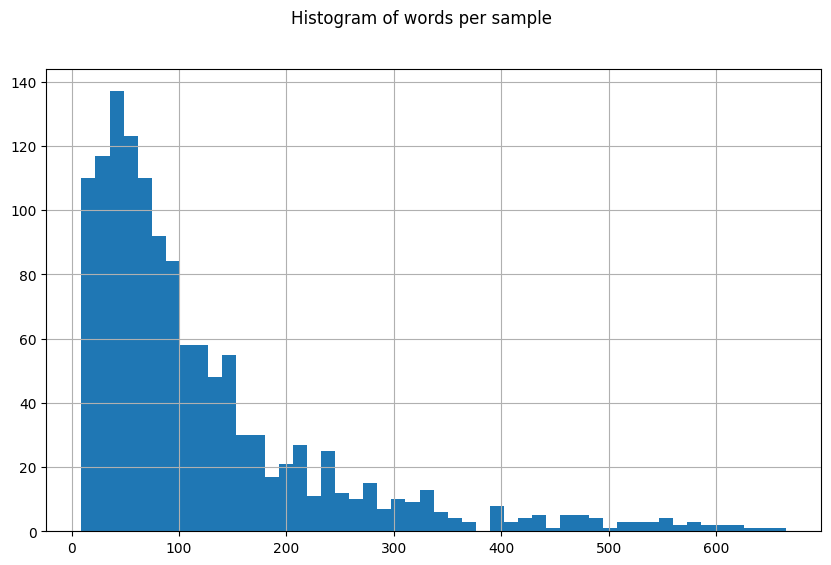

In [39]:
# histogram of words per sample
df_word_list.apply(lambda r: len(r)).hist(bins=50, figsize=(10, 6))
plt.suptitle('Histogram of words per sample')

Text(0.5, 0.98, 'Frequency of the 50 most common words in the dataset')

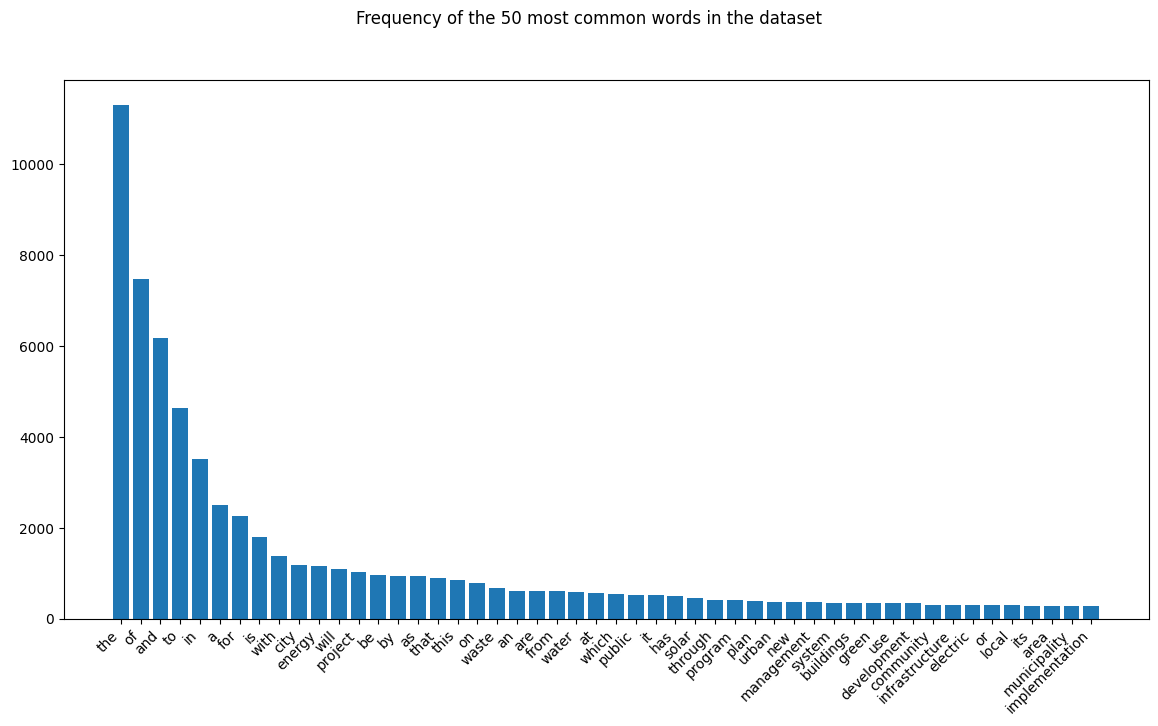

In [40]:
# frequency graph for the most common words
num_words = 50
words = df_word_list.agg('sum')
uniques, unique_counts = np.unique(words, return_counts=True)
sorted_index = np.argsort(unique_counts)[::-1]
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45, ha='right')
plt.bar(uniques[sorted_index][:num_words], unique_counts[sorted_index][:num_words])
plt.suptitle(f'Frequency of the {num_words} most common words in the dataset')

In [41]:

# samples / number of words per sample ratio
# metric suggested by google to determine the approach to solving the problem
# ratio < 1500 suggests tokenizing text as n-grams instead of tokenizing as sequences
# in other words, a small ratio suggests we use simpler approaches to the problem
df_words_per_sample = df_word_list.apply(lambda r: len(r))
ratio = len(df_words_per_sample) / df_words_per_sample.mean()
ratio

10.819108183140735